# Imports

In [15]:
import numpy as np
import os
from PIL import Image
import cv2
import copy
from glob import glob

import ObjectDetection.Open3D_ML.ml3d as _ml3d
import ObjectDetection.Open3D_ML.ml3d.torch as tml3d
from ObjectDetection.TaskDataset import TaskDataset

# 3D Object Detection

## Choosen Model

PointPillars

## Model Setup

Implemented most of the dataloading and preprocessing in TaskDataset.py <br>
Load model weigths from pointpillars_waymo.pth <br>
The model configuration and general pipelinesettings are defined in pointpillars_waymo.yml

In [16]:
cfg_file = "ObjectDetection/pointpillars_waymo.yml"
# cfg_file = "/workspaces/AutomotiveVehicles/Assignment2/ObjectDetection/pointpillars_kitti.yml"
cfg =  _ml3d.utils.Config.load_from_file(cfg_file)

model = tml3d.models.PointPillars(**cfg.model)
dataset = TaskDataset(cfg.dataset)
pipeline = tml3d.pipelines.ObjectDetection(model, dataset=dataset, device="gpu", **cfg.pipeline)

# download the weights.
ckpt_folder = "./logs/"
os.makedirs(ckpt_folder, exist_ok=True)
ckpt= "pointpillars_waymo_202211200158utc_seed2_gpu16.pth"
# ckpt = "pointpillars_kitti_202012221652utc.pth"
ckpt_path = ckpt_folder + ckpt
pointpillar_url = f"https://storage.googleapis.com/open3d-releases/model-zoo/{ckpt}"
if not os.path.exists(ckpt_path):
    cmd = "wget {} -O {}".format(pointpillar_url, ckpt_path)
    os.system(cmd)

# load the parameters.
pipeline.load_ckpt(ckpt_path=ckpt_path)

0

In [17]:
test_split = dataset.get_split("test")
print("Number of samples: ", len(test_split))

Number of samples:  199


In [18]:
pipeline.run_valid()

validation: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [14]:
files = glob("logs/PointPillars_MyDataset_torch/*.txt")
files.sort()
with open(files[-1], "r") as f:
    lines = f.read()
print(lines)

Started validation
validation -  loss_cls: 1.223 loss_bbox: 5.661 loss_dir: 0.444 > loss: 7.328

=============== mAP BEV ===============
class \ difficulty      0     1     2 
VEHICLE:             28.41 28.41 28.41 
PEDESTRIAN:           0.00  0.00  0.00 
CYCLIST:              0.00  0.00  0.00 
Overall: 9.47

=============== mAP  3D ===============
class \ difficulty      0     1     2 
VEHICLE:             28.88 28.88 28.88 
PEDESTRIAN:           0.00  0.00  0.00 
CYCLIST:              0.00  0.00  0.00 
Overall: 9.63



In [19]:
data = test_split.get_data(15)
result = pipeline.run_inference(data)
pcl = data["point"]
result

[[box:10938 (class=VEHICLE, conf=0.40305018),
  box:10939 (class=VEHICLE, conf=0.24465704),
  box:10940 (class=VEHICLE, conf=0.21565245),
  box:10941 (class=VEHICLE, conf=0.17358975),
  box:10942 (class=VEHICLE, conf=0.16093527),
  box:10943 (class=VEHICLE, conf=0.15597145),
  box:10944 (class=VEHICLE, conf=0.13537495),
  box:10945 (class=VEHICLE, conf=0.12345414),
  box:10946 (class=VEHICLE, conf=0.121407144),
  box:10947 (class=VEHICLE, conf=0.10770502),
  box:10948 (class=VEHICLE, conf=0.103943884),
  box:10949 (class=PEDESTRIAN, conf=0.13159445),
  box:10950 (class=PEDESTRIAN, conf=0.11401507)]]

In [20]:
from easydict import EasyDict as edict
from typing import Tuple

def pcl_to_bev(pcl:np.ndarray, configs: edict) -> np.ndarray:
    """Computes the bev map of a given pointcloud. 
    
    For generality, this method can return the bev map of the available 
    channels listed in '''BEVConfig.VALID_CHANNELS'''. 

    Parameters
    ----------
        pcl (np.ndarray): pointcloud as a numpy array of shape [n_points, m_channles] 
        configs (Dict): configuration parameters of the resulting bev_map

    Returns
    -------
        bev_map (np.ndarray): bev_map as numpy array of shape [len(config.channels), configs.bev_height, configs.bev_width ]
    """
    
    # remove lidar points outside detection area and with too low reflectivity
    mask = np.where((pcl[:, 0] >= configs.lims.x[0]) & (pcl[:, 0] <= configs.lims.x[1]) &
                    (pcl[:, 1] >= configs.lims.y[0]) & (pcl[:, 1] <= configs.lims.y[1]) &
                    (pcl[:, 2] >= configs.lims.z[0]) & (pcl[:, 2] <= configs.lims.z[1]))
    pcl = pcl[mask]

    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    pcl[:, 2] = pcl[:, 2] - configs.lims.z[0]  

    # Convert sensor coordinates to bev-map coordinates (center is bottom-middle)
    # compute bev-map discretization by dividing x-range by the bev-image height
    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width
    ## transform all metrix x-coordinates into bev-image coordinates    
    pcl_cpy = np.copy(pcl)
    pcl_cpy[:, 0] = np.int_(np.floor(pcl_cpy[:, 0] / bev_x_discret))
    # transform all y-coordinates making sure that no negative bev-coordinates occur
    pcl_cpy[:, 1] = np.int_(np.floor(pcl_cpy[:, 1] / bev_y_discret) + (configs.bev_width + 1) / 2) 
    # Create BEV map
    bev_map = np.zeros((3, configs.bev_height, configs.bev_width))
    # Compute height and density channel
    pcl_height_sorted, counts = sort_and_map(pcl_cpy, 2, return_counts=True)
    xs = np.int_(pcl_height_sorted[:, 0])
    ys = np.int_(pcl_height_sorted[:, 1])
    # Fill height map
    normalized_height = pcl_height_sorted[:, 2]/float(np.abs(configs.lims.z[1] - configs.lims.z[0]))
    height_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    height_map[xs,ys] = normalized_height
    
    # Fill density map
    normalized_density = np.minimum(1.0, np.log(counts + 1) / np.log(64))
    density_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    density_map[xs,ys] = normalized_density

    # Compute intesity channel
    pcl_cpy[pcl_cpy[:,3]>configs.lims.intensity[1],3] = configs.lims.intensity[1]
    pcl_cpy[pcl_cpy[:,3]<configs.lims.intensity[0],3] = configs.lims.intensity[0]
    
    pcl_int_sorted, _ = sort_and_map(pcl_cpy, 3, return_counts=False)
    xs = np.int_(pcl_int_sorted[:, 0])
    ys = np.int_(pcl_int_sorted[:, 1])
    normalized_int = pcl_int_sorted[:, 3]/(np.amax(pcl_int_sorted[:, 3])-np.amin(pcl_int_sorted[:, 3]))
    intensity_map = np.zeros((configs.bev_height + 1, configs.bev_width + 1))
    intensity_map[xs,ys] = normalized_int
    
    # Fill BEV 
    bev_map[2,:,:] = density_map[:configs.bev_height, :configs.bev_width]
    bev_map[1,:,:] = height_map[:configs.bev_height, :configs.bev_width]
    bev_map[0,:,:] = intensity_map[:configs.bev_height, :configs.bev_width]
 
    return bev_map

def sort_and_map(pcl: np.ndarray, channel_index: int, return_counts:bool=False) ->Tuple[np.ndarray,np.ndarray]:
    """Function to re-arrange elements in poincloud by sorting first by x, then y, then -channel.
    This function allows users to map a pointcloud channel to a top view image (in z axis) of that channel.

    Parameters
    ----------
        pcl (np.ndarray): Input pointcloud of of shape [n_points, m_channles]
        channel_index (int): Index of channel to take into account as third factor, 
                             when sorting the pointcloud.
        return_counts (bool): True to return the counts on points per cell. Used for density channel
    Returns
     ----------
       channel_map (np.ndarray): [description]
       counts (np.ndarray): [description]
       
    """

    idx= np.lexsort((-pcl[:, channel_index], pcl[:, 1], pcl[:, 0]))
    pcl_sorted = pcl[idx]
    counts = None
    # extract all points with identical x and y such that only the maximum value of the channel is kept
    if return_counts:
        _, indices, counts = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True, return_counts=return_counts)
    else:
        _, indices = np.unique(pcl_sorted[:, 0:2], axis=0, return_index=True)
    return (pcl_sorted[indices], counts)

def show_bev_map(bev_map: np.ndarray) -> None:
    """Function to show bev_map as an RGB image

    By default, the image will only show the 3 first channels of `bev_map`. 

    Parameters
    ----------
        bev_map (np.ndarray): bev_map as numpy array of shape `[len(config.channels), configs.bev_height, configs.bev_width ]` 
    """
    bev_image: np.ndarray =  (np.swapaxes(np.swapaxes(bev_map,0,1),1,2)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])


    height_image = Image.fromarray(np.dstack((bev_image[:, :, 0],mask,mask)))
    den_image = Image.fromarray(np.dstack((mask,bev_image[:, :, 1],mask)))
    int_image = Image.fromarray(np.dstack((mask,mask,bev_image[:, :, 2])))

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()

In [21]:
from numpy import sin, cos

def rotated_rectangle(image, center_point, height, width, angle, color, thickness, ):
    # Determine the coordinates of the 4 corner points
    rotated_rect_points = []
    x = center_point[0] + ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) - ((height / 2) * sin(angle))
    y = center_point[1] - ((width / 2) * sin(angle)) + ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] - ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1]- ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    x = center_point[0] + ((width / 2) * cos(angle)) + ((height / 2) * sin(angle))
    y = center_point[1] + ((width / 2) * sin(angle)) - ((height / 2) * cos(angle))
    rotated_rect_points.append([x,y])
    return cv2.polylines(image, np.array([rotated_rect_points], np.int32), True, color, thickness)

In [26]:
def show_bounding_boxes(bev_map: np.ndarray, configs, labels, pred) -> np.ndarray:
    bev_image: np.ndarray =  (np.moveaxis(bev_map, 0, -1)*255).astype(np.uint8)
    mask: np.ndarray = np.zeros_like(bev_image[:,:,0])

    height_image = np.dstack((bev_image[:, :, 0],mask,mask))
    den_image = np.dstack((mask,bev_image[:, :, 1],mask))
    int_image = np.dstack((mask,mask,bev_image[:, :, 2]))

    bev_x_discret = (configs.lims.x[1] - configs.lims.x[0]) / configs.bev_height
    bev_y_discret = (configs.lims.y[1] - configs.lims.y[0]) / configs.bev_width


    for boxes, color in zip([labels, pred], [[200, 0, 200], [0, 200, 200]]):
        for box in boxes:
            x, y, z, l, w, h, r = box.to_xyzwhlr()

            x = np.int_(np.floor(x / bev_x_discret))
            l = np.int_(np.floor(l / bev_x_discret))
            y = np.int_(np.floor(y / bev_y_discret) + (configs.bev_width + 1) / 2)
            w = np.int_(np.floor(w / bev_y_discret))

            int_image = rotated_rectangle(int_image, (y, x), l, w, r, color, 1)
            den_image = rotated_rectangle(den_image, (y, x), l, w, r, color, 1)
            height_image = rotated_rectangle(height_image, (y, x), l, w, r, color, 1)
            bev_image = rotated_rectangle(bev_image.copy(), (y, x), l, w, r, color, 1)
        
    height_image = Image.fromarray(height_image)
    den_image = Image.fromarray(den_image)
    int_image = Image.fromarray(int_image)

    int_image.show()
    den_image.show()
    height_image.show()
    Image.fromarray(bev_image).show()
    


configs = edict()
configs.lims = edict()
configs.lims.x = [0, 50]
configs.lims.y = [-25, 25]
configs.lims.z = [-1.5, 3]
configs.lims.intensity = [0, 1.0]
configs.bev_height = 640
configs.bev_width = 640

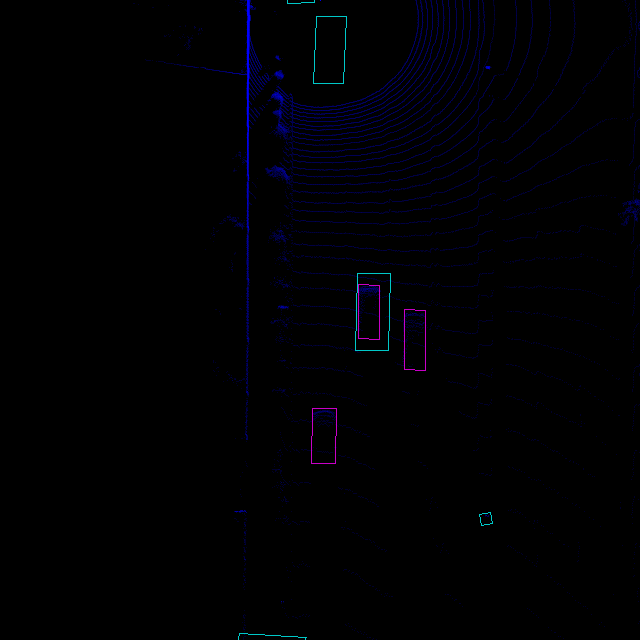

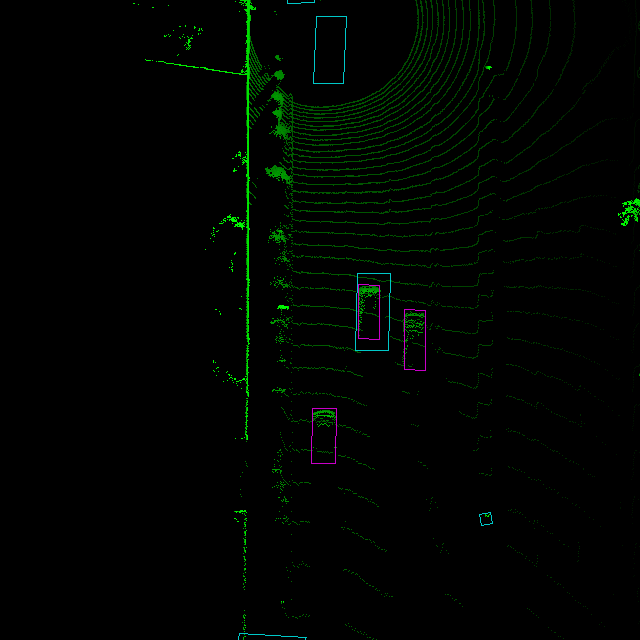

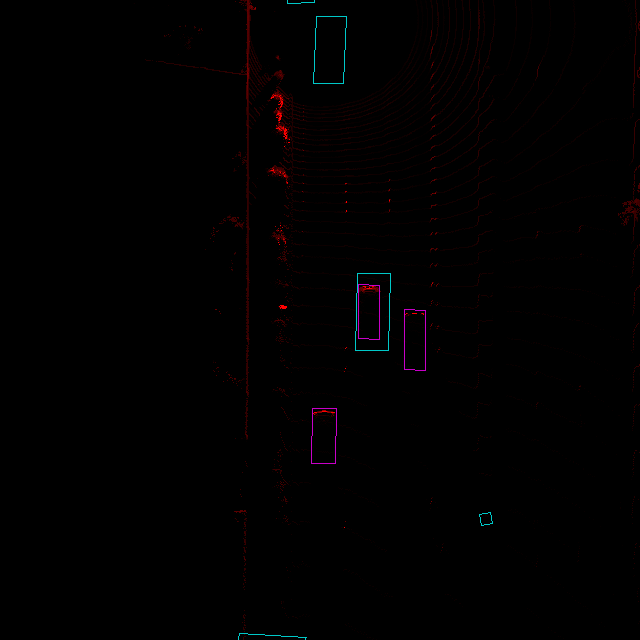

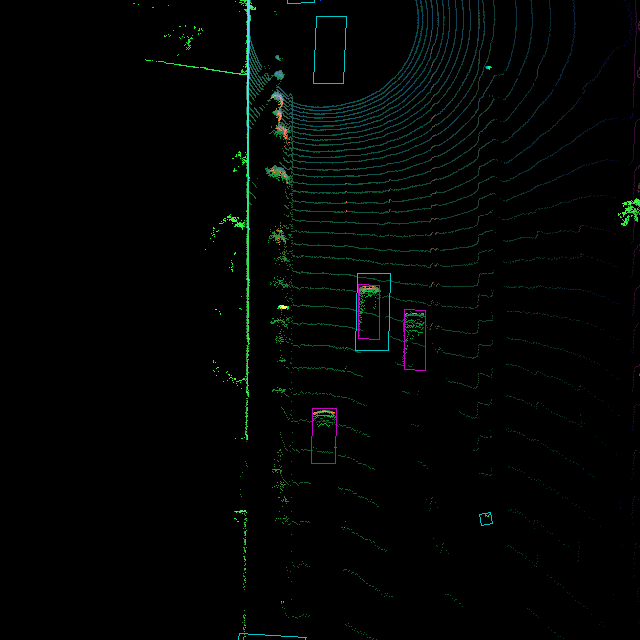

In [27]:
bev_map = pcl_to_bev(pcl, configs)
show_bounding_boxes(bev_map, configs, data["bounding_boxes"], result[0])